In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm  # For Xception

In [3]:
pip install timm


   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.4 MB 958.5 kB/s eta 0:00:02
   ------------- -------------------------- 0.8/2.4 MB 958.5 kB/s eta 0:00:02
   ----------------- ---------------------- 1.0/2.4 MB 986.7 kB/s eta 0:00:02
   ---------------------- ----------------- 1.3/2.4 MB 1.0 MB/s eta 0:00:02
   ---------------------- ----------------- 1.3/2.4 MB 1.0 MB/s eta 0:00:02
   ------------------------------- -------- 1.8/2.4 MB 1.0 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 1.0 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 990.3 kB/s eta 0:00:00
Note: you may need to restart th

In [7]:
# Dataset preparation
data_dir = r"C:\Users\Ahmed Atef\OneDrive\Desktop\Pr-Deep\archive\LFW"  # Update with your path
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

lfw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(lfw_dataset, batch_size=32, shuffle=True)
num_classes = len(lfw_dataset.classes)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def get_xception(num_classes):
    model = timm.create_model('xception', pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer
    return model

In [12]:
def get_densenet(num_classes):
    model = models.densenet121(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Modify the final layer
    return model

# Choose a model
use_xception = True  # Set to False to use DenseNet

if use_xception:
    model = get_xception(num_classes)
    print("Using Xception Model")
else:
    model = get_densenet(num_classes)
    print("Using DenseNet Model")

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using Xception Model


In [14]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}")

# Save the model
model_name = "xception" if use_xception else "densenet"
torch.save(model.state_dict(), f"{model_name}_transfer_learning.pth")
print(f"Model trained and saved as {model_name}_transfer_learning.pth")

Epoch [1/5], Loss: 4.4237
Epoch [2/5], Loss: 3.7795
Epoch [3/5], Loss: 3.0738
Epoch [4/5], Loss: 2.2433
Epoch [5/5], Loss: 1.8636
Model trained and saved as xception_transfer_learning.pth


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [28]:
def get_predictions(model, data_loader):
    model.eval()
    y_true = []
    y_preds = []
    y_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_preds.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_preds), np.array(y_probs)

# Accuracy
def show_accuracy(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy:.4f}")

In [1]:
# Confusion Matrix
def show_confusion_matrix(y_true, y_preds, class_names):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show

SyntaxError: keyword argument repeated: fmt (3834269662.py, line 15)

In [32]:
def show_classification_report(y_true, y_preds, class_names):
    report = classification_report(y_true, y_preds, target_names=class_names, digits=4)
    print("\nClassification Report:")
    print(report)

In [34]:
# ROC and AUC
def show_roc_auc(y_true, y_probs, class_names):
    plt.figure(figsize=(10, 7))
    num_classes = len(class_names)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC and AUC')
    plt.legend()
    plt.show()

In [38]:
y_true, y_preds, y_probs = get_predictions(model, data_loader)

# Display metrics individually
show_accuracy(y_true, y_preds)

Accuracy: 0.6970


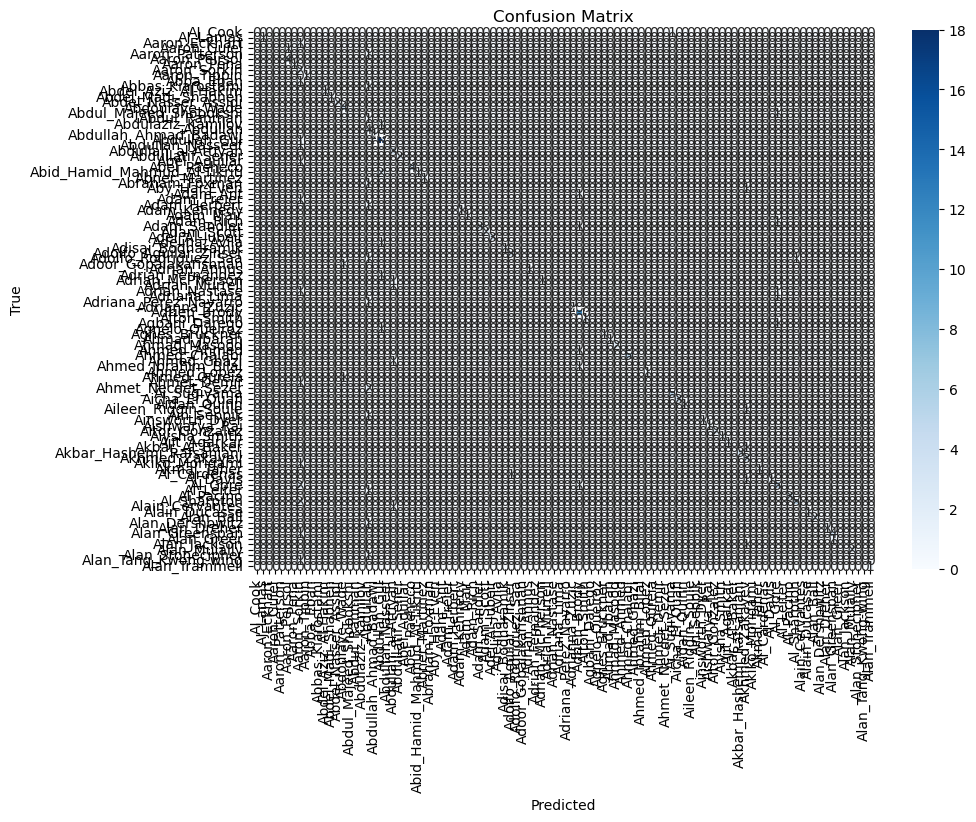

In [40]:
show_confusion_matrix(y_true, y_preds, lfw_dataset.classes) # Confusion Matrix

In [41]:
show_classification_report(y_true, y_preds, lfw_dataset.classes) # Precision, Recall, F1-Score


Classification Report:
                              precision    recall  f1-score   support

                     AJ_Cook     0.0000    0.0000    0.0000         1
                    AJ_Lamas     1.0000    1.0000    1.0000         1
               Aaron_Eckhart     0.0000    0.0000    0.0000         1
                 Aaron_Guiel     0.0000    0.0000    0.0000         1
             Aaron_Patterson     0.0000    0.0000    0.0000         1
               Aaron_Peirsol     0.8000    1.0000    0.8889         4
                  Aaron_Pena     1.0000    1.0000    1.0000         1
                Aaron_Sorkin     0.1176    1.0000    0.2105         2
                Aaron_Tippin     1.0000    1.0000    1.0000         1
                   Abba_Eban     0.0000    0.0000    0.0000         1
            Abbas_Kiarostami     0.0000    0.0000    0.0000         1
         Abdel_Aziz_Al-Hakim     1.0000    1.0000    1.0000         1
          Abdel_Madi_Shabneh     1.0000    1.0000    1.0000      

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


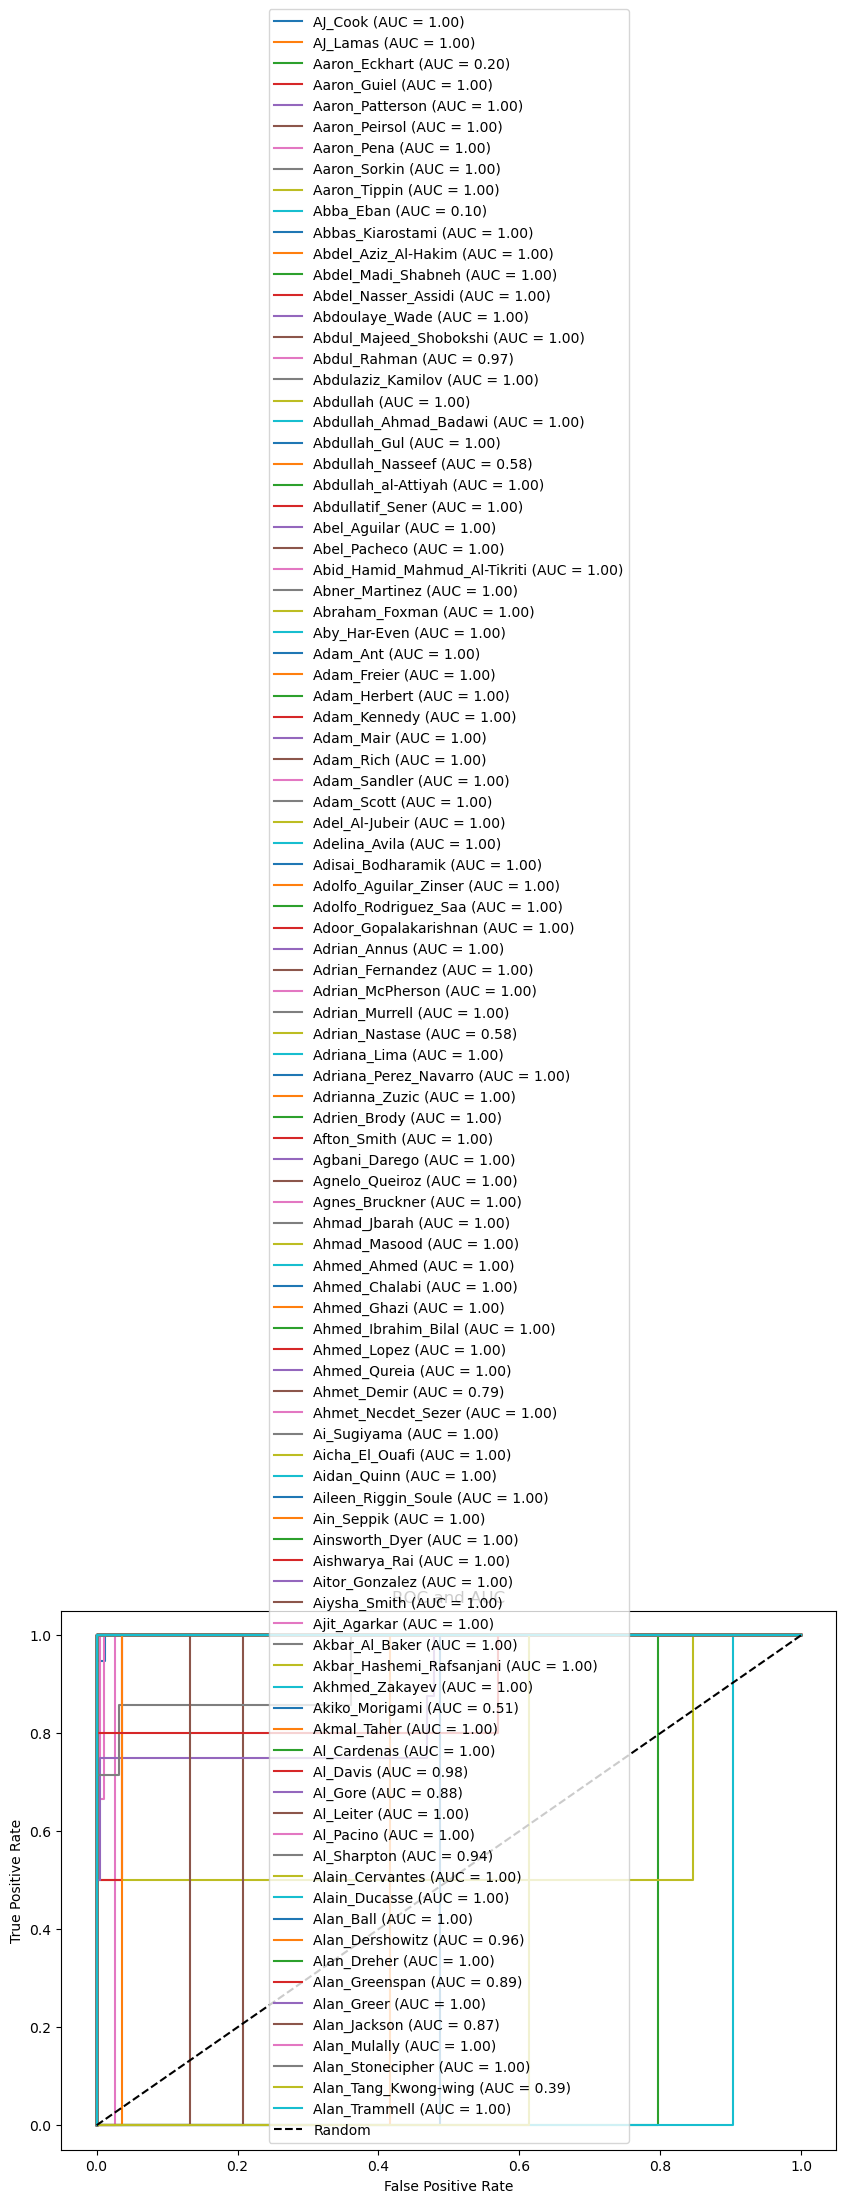

In [44]:
show_roc_auc(y_true, y_probs, lfw_dataset.classes)          # ROC and AUC